# Pytorch_Geometric : Learning to use PyGeo

#### This notebook is adapted from a series of videos from Antonio Longa(links: https://github.com/AntonioLonga/PytorchGeometricTutorial and https://www.youtube.com/watch?v=JtDgmmQ60x8&list=PLGMXrbDNfqTzqxB1IGgimuhtfAhGd8lHF&pp=iAQB )

### Import Librairies

In [1]:
#for part 2
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GAE
import torch_geometric.transforms as T

#for GVAE
from torch_geometric.nn import VGAE

#for part 3
import os.path
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score,homogeneity_score, completeness_score
from sklearn.manifold import TSNE
from torch_geometric.nn.models.autoencoder import ARGVA
import random

import matplotlib.pyplot as plt

import session_info

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
session_info.show()

## Part 2 : Graph Autoencoders and Variational Graph Autoencoders

### GAE : GraphAutoEncoder

#### Loading the dataset

In [2]:
dataset= Planetoid(root='exploration_citeseer',name="CiteSeer", transform= T.NormalizeFeatures())
print(dataset._data)
print(dataset.num_classes)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
6


In [3]:
# As autoencoder is an unsupervised learning method, reshape of the dataset can be performed(we don't need the masks or even y)
data=dataset[0]# we have just one graph in this dataset
data.train_mask=data.test_mask= data.val_mask= None
transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=False, key='edge_label',split_labels = True)
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)

Data(x=[3327, 3703], edge_index=[2, 7739], y=[3327], pos_edge_label=[7739], pos_edge_label_index=[2, 7739], neg_edge_label=[7739], neg_edge_label_index=[2, 7739])
Data(x=[3327, 3703], edge_index=[2, 7739], y=[3327], pos_edge_label=[455], pos_edge_label_index=[2, 455], neg_edge_label=[455], neg_edge_label_index=[2, 455])
Data(x=[3327, 3703], edge_index=[2, 8194], y=[3327], pos_edge_label=[910], pos_edge_label_index=[2, 910], neg_edge_label=[910], neg_edge_label_index=[2, 910])


#### Define Encoder 

In [4]:
class GCN_Encod(torch.nn.Module):
    def __init__(self, in_channels,out_channels):
        super(GCN_Encod,self).__init__()
        
        self.conv1= GCNConv(in_channels, 2*out_channels, cached= True)
        self.conv2= GCNConv(2*out_channels, out_channels, cached= True)
        
        
    def forward(self,x, edge_index):
        
        x= self.conv1(x, edge_index).relu()
        x= self.conv2(x, edge_index)
        return x
    

#### Define Autoencoder 

In [5]:
# Hyperparameters
out_channels = 2
num_features= dataset.num_features
num_epoch=500

#model
model= GAE(GCN_Encod(num_features, out_channels))
# use the GPU
model=model.to(device)
x=train_data.x.to(device)
train_edge_index= train_data['pos_edge_label_index'].to(device)
train_neg_edge_index= train_data['neg_edge_label_index'].to(device)

#optimizer
optimizer= torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [6]:
print(model)

GAE(
  (encoder): GCN_Encod(
    (conv1): GCNConv(3703, 4)
    (conv2): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)


In [7]:
for epoch in range(num_epoch):  # loop over the dataset multiple times
    model.train()
    optimizer.zero_grad()
    z= model.encode(x, train_edge_index)
    loss = model.recon_loss(z, train_edge_index,train_neg_edge_index)
    loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        z= model.encode(test_data.x.to(device),test_data['pos_edge_label_index'].to(device))
        auc,ap = model.test(z, test_data['pos_edge_label_index'].to(device), test_data['neg_edge_label_index'].to(device))
    
    if (epoch+1) % 100 ==0:
         print (f'epoch {epoch+1}/{num_epoch}, Loss= {loss:.3f}, AUC = {auc:.5f}, AP= {ap:.4f}')
    

epoch 100/500, Loss= 1.354, AUC = 0.73570, AP= 0.7569
epoch 200/500, Loss= 1.305, AUC = 0.71921, AP= 0.7645
epoch 300/500, Loss= 1.245, AUC = 0.75854, AP= 0.7873
epoch 400/500, Loss= 1.181, AUC = 0.81451, AP= 0.8183
epoch 500/500, Loss= 1.128, AUC = 0.83185, AP= 0.8309


In [8]:
Z= model.encode(x,train_edge_index) 
Z

tensor([[-0.1630,  0.0518],
        [-0.5179,  0.3265],
        [ 0.3107, -0.3168],
        ...,
        [-0.2898,  0.1521],
        [ 0.4933, -0.4588],
        [ 0.5081, -0.4708]], device='cuda:0', grad_fn=<AddBackward0>)

### GVAE : Graph Variational AutoEncoder

In [9]:
# we retake the same dataset,with the same preprocessing

In [10]:
class Varia_GCN_Encod(torch.nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Varia_GCN_Encod,self).__init__()
        
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached= True)
        self.conv_mu = GCNConv(2*out_channels, out_channels, cached= True)
        self.conv_logstd = GCNConv(2*out_channels, out_channels, cached= True)
        
    def forward(self,x, edge_index):
        
        x= self.conv1(x, edge_index).relu()
        y,z= self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
        return y,z

In [11]:
# Hyperparameters
out_channels = 2
num_features= dataset.num_features
num_epoch=500

#model
model= VGAE(Varia_GCN_Encod(num_features, out_channels))
# use the GPU
model=model.to(device)
x=train_data.x.to(device)
train_edge_index= train_data['pos_edge_label_index'].to(device)
train_neg_edge_index= train_data['neg_edge_label_index'].to(device)

#optimizer
optimizer= torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-8)
print(model)

VGAE(
  (encoder): Varia_GCN_Encod(
    (conv1): GCNConv(3703, 4)
    (conv_mu): GCNConv(4, 2)
    (conv_logstd): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)


In [12]:
for epoch in range(num_epoch):  # loop over the dataset multiple times
    model.train()
    optimizer.zero_grad()
    z= model.encode(x, train_edge_index)
    loss = model.recon_loss(z, train_edge_index,train_neg_edge_index)
    
    loss= loss + (1/data.num_nodes)* model.kl_loss() # The only new line
    loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        z= model.encode(train_data.x.to(device),train_data['pos_edge_label_index'].to(device))
        auc,ap = model.test(z, test_data['pos_edge_label_index'].to(device), test_data['neg_edge_label_index'].to(device))
    
    if (epoch+1) % 100 ==0:
         print (f'epoch {epoch+1}/{num_epoch}, Loss= {loss:.3f}, AUC = {auc:.5f}, AP= {ap:.4f}')
    

epoch 100/500, Loss= 1.387, AUC = 0.52505, AP= 0.5306
epoch 200/500, Loss= 1.276, AUC = 0.70112, AP= 0.7468
epoch 300/500, Loss= 1.050, AUC = 0.82061, AP= 0.8227
epoch 400/500, Loss= 0.971, AUC = 0.81044, AP= 0.8107
epoch 500/500, Loss= 0.933, AUC = 0.79938, AP= 0.7944


## Part 3 : Adversarial Regularizer Graph Autoencoders 

#### Get the data

In [13]:
dataset= Planetoid(root='exploration_cora',name="Cora", transform= T.NormalizeFeatures())
data= dataset.get(0)

#### Get the number_of_nodes in the graph

In [14]:
num_nodes= data.num_nodes
print(num_nodes)

2708


#### Create the test/train/val data

In [15]:
data.train_mask = data.test_mask = data.val_mask = None
transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=False, key='edge_label',split_labels = True)
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)

Data(x=[2708, 1433], edge_index=[2, 8974], y=[2708], pos_edge_label=[8974], pos_edge_label_index=[2, 8974], neg_edge_label=[8974], neg_edge_label_index=[2, 8974])
Data(x=[2708, 1433], edge_index=[2, 8974], y=[2708], pos_edge_label=[527], pos_edge_label_index=[2, 527], neg_edge_label=[527], neg_edge_label_index=[2, 527])
Data(x=[2708, 1433], edge_index=[2, 9501], y=[2708], pos_edge_label=[1055], pos_edge_label_index=[2, 1055], neg_edge_label=[1055], neg_edge_label_index=[2, 1055])


#### Define the parts of the model

In [16]:
#The encoder is the same than the previous one
class Varia_GCN_Encod(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Varia_GCN_Encod,self).__init__()
        
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached= True)
        self.conv_mu = GCNConv(2*out_channels, out_channels, cached= True)
        self.conv_logstd = GCNConv(2*out_channels, out_channels, cached= True)
        
    def forward(self,x, edge_index):
        
        x= torch.nn.functional.relu(self.conv1(x, edge_index))
        y,z= self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
        return y,z


In [17]:
# Define the discrimator
class Discriminator(nn.Module):
    def __init__(self, in_channels,hidden_channels,out_channels):
        super(Discriminator,self).__init__()
        self.fc1= nn.Linear(in_channels,hidden_channels)
        self.fc2= nn.Linear(hidden_channels,hidden_channels)
        self.fc3= nn.Linear(hidden_channels,out_channels)
        
    def forward(self,x):
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        outputs= self.fc3(x)
        return outputs

#### Model initialization

In [18]:
# Hyperparameters
latent_space= 32
out_channels = 1
num_features= data.num_features
hidden_channels= 64
num_epoch=200

#model
encoder = Varia_GCN_Encod(in_channels=num_features,out_channels= latent_space)
discriminator= Discriminator(in_channels=latent_space, hidden_channels=hidden_channels,out_channels=out_channels)

model= ARGVA(encoder,discriminator)

# use the GPU
model=model.to(device)
x=train_data.x.to(device)
train_edge_index= train_data.pos_edge_label_index.to(device)
train_neg_edge_index= train_data.neg_edge_label_index.to(device)

#optimizer
discriminator_optimizer= torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer= torch.optim.Adam(encoder.parameters(), lr=0.005)
print(model)

ARGVA(
  (encoder): Varia_GCN_Encod(
    (conv1): GCNConv(1433, 64)
    (conv_mu): GCNConv(64, 32)
    (conv_logstd): GCNConv(64, 32)
  )
  (decoder): InnerProductDecoder()
  (discriminator): Discriminator(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
  )
  (VGAE): VGAE(
    (encoder): Varia_GCN_Encod(
      (conv1): GCNConv(1433, 64)
      (conv_mu): GCNConv(64, 32)
      (conv_logstd): GCNConv(64, 32)
    )
    (decoder): InnerProductDecoder()
  )
)


#### Loop for training and test

In [19]:
for epoch in range(num_epoch):
    model.train()
    encoder_optimizer.zero_grad()
    z= model.encode(x, train_edge_index)
    
    for i in range (5):
        idx = list(range(num_nodes))
        random.shuffle(idx) 
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss= model.discriminator_loss(z[idx])
        discriminator_loss.backward(retain_graph= True)
        discriminator_optimizer.step()
        
    loss = 0
    loss = loss + model.reg_loss(z)
    loss = loss + model.recon_loss(z, train_edge_index)
    
    loss= loss + (1/data.num_nodes)* model.kl_loss() # The only new line
    loss.backward()
    encoder_optimizer.step()
    
    if (epoch+1) % 10 ==0:
        with torch.no_grad():
            model.eval()
            z= model.encode(train_data.x.to(device),train_data.pos_edge_label_index.to(device))
            auc,ap = model.test(z, test_data.pos_edge_label_index.to(device), test_data.neg_edge_label_index.to(device))

            # Cluster embedded values using k-means
            KM_input= z.to('cpu').numpy()
            KM= KMeans(n_clusters=7, random_state=5).fit(KM_input)
            preds= KM.predict(KM_input)

            labels= data.y.to('cpu').numpy()
            completeness= completeness_score(labels,preds)
            hm= homogeneity_score(labels,preds)
            nmi= v_measure_score(labels, preds)

            print(f'epoch {epoch+1}/{num_epoch}, Loss= {loss:.3f}, AUC = {auc:.5f}, AP= {ap:.4f},Completeness= {completeness:.3f}, Homogeneity = {hm:.3f},Nmi= {nmi:.3f}')

epoch 10/200, Loss= 2.211, AUC = 0.79422, AP= 0.7999,Completeness= 0.200, Homogeneity = 0.196,Nmi= 0.198
epoch 20/200, Loss= 2.585, AUC = 0.84868, AP= 0.8462,Completeness= 0.321, Homogeneity = 0.324,Nmi= 0.322
epoch 30/200, Loss= 3.708, AUC = 0.86614, AP= 0.8577,Completeness= 0.390, Homogeneity = 0.387,Nmi= 0.388
epoch 40/200, Loss= 4.172, AUC = 0.87167, AP= 0.8714,Completeness= 0.471, Homogeneity = 0.438,Nmi= 0.454
epoch 50/200, Loss= 4.029, AUC = 0.88493, AP= 0.8707,Completeness= 0.397, Homogeneity = 0.392,Nmi= 0.395
epoch 60/200, Loss= 3.862, AUC = 0.89227, AP= 0.8749,Completeness= 0.426, Homogeneity = 0.423,Nmi= 0.424
epoch 70/200, Loss= 4.125, AUC = 0.90848, AP= 0.8990,Completeness= 0.462, Homogeneity = 0.452,Nmi= 0.457
epoch 80/200, Loss= 3.987, AUC = 0.91859, AP= 0.9123,Completeness= 0.562, Homogeneity = 0.530,Nmi= 0.545
epoch 90/200, Loss= 3.969, AUC = 0.92729, AP= 0.9231,Completeness= 0.554, Homogeneity = 0.525,Nmi= 0.539
epoch 100/200, Loss= 3.792, AUC = 0.93156, AP= 0.9262,C

#### Visualisation of clustering from this VAE

C:\Users\sylv_\anaconda3\envs\Pytorch_Chem\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sylv_\anaconda3\envs\Pytorch_Chem\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


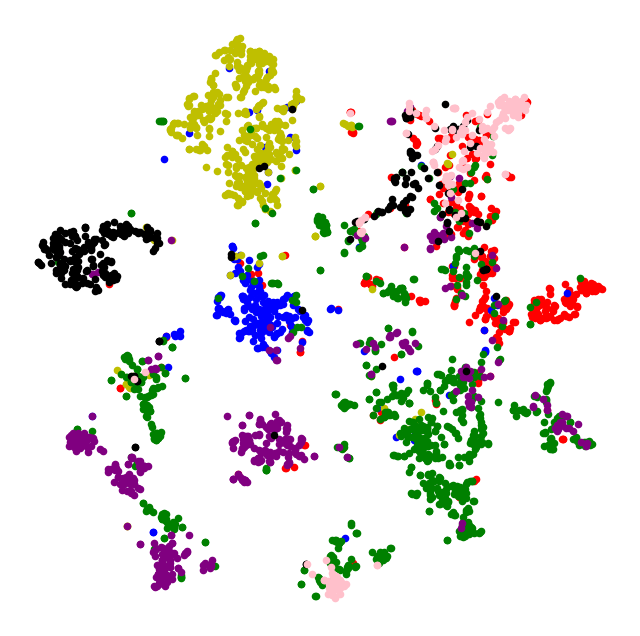

In [20]:
colors=['r','b','y','g','purple','black','pink']
with torch.no_grad():
    model.to(device)
    model.eval()
    z = model.encode(train_data.x.to(device),train_data.pos_edge_label_index.to(device))
    z = TSNE(n_components=2).fit_transform(z.to('cpu').numpy())
    y = data.y.to('cpu').numpy()
    
    fig= plt.figure(1, figsize=(8,8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i,0],z[y == i,1], s=20, c=colors[i])
    plt.axis('off')
    plt.show